# <center>Aprendizaje Automático Avanzado: Ejercicio final</center>
### <center>Autor: Julen Ercibengoa</center>

## 1. Contexto

Actualmente estoy trabajando en la empresa **Tekniker** la cual está involucrada en el proyecto GAIA. Este es un proyecto que pretende dar apoyo a los servicios de extinción de incendios forestales mediante herramientas de prevención y detección temprana utilizando la Inteligencia Artificial.

Mi trabajo consiste en crear un modelo de Aprendizaje Automático que prediga el riesgo de incendio forestal a nivel nacional diariamente. Es decir, el objetivo final del trabajo (el cual es mi Trabajo de Fin de Máster), es generar un modelo que con los datos disponibles hasta hoy, genere un mapa de mañana de riesgo de incendio forestal en toda España. 

Para conseguir ese objetivo hacen falta varios pasos, y este trabajo será uno de ellos. En este trabajo haremos una primera prueba y generaremos un predictor de riesgo de incendio forestal que prediga el riesgo de incendio forestal mensual. Además, haremos varios análisis para decidir qué variable son relevantes para el modelo.

## 2. Bases de Datos

Para predecir el riesgo de incendio forestal hay que generar una base de datos con la cual entrenar un modelo de Inteligencia Artificial. En el estado del arte [(Ver el análisis del estado del arte)](SOTA.pdf) se sigue una metodología común que vamos a utilizar: se divide la región a analizar en celdas espacio-temporales y cada celda tiene asignadas variables tabulares. Para generar dicha base de datos, vamos a utilizar las siguientes fuentes de datos:
- <u>Datos históricos de fuegos</u>: base de datos de [EFFIS](https://forest-fire.emergency.copernicus.eu/)
- <u>Datos del tipo de terreno</u>: base de datos [Corine Land Cover](https://land.copernicus.eu/en/products/corine-land-cover)
- <u>Datos DEM (Digital Elevation Model)</u>: base de datos de [EU DEM](https://portal.opentopography.org/raster?opentopoID=OTSDEM.032021.4326.3&minX=-17.18261718749999&minY=31.097629956393973&maxX=15.952148437499998&maxY=45.43508099838451)
- <u>Distancia a carreteras</u>, <u>distancia a rios</u> y <u>densidad poblacional</u>: [WorldPop](https://www.worldpop.org/)
- <u>Distancia a vías de tren</u>: [OpenStreetMap](https://www.openstreetmap.org/#map=6/40.01/-2.49)
- <u>Proporción de natura2000</u>: [Gobierno de España](https://www.miteco.gob.es/es/biodiversidad/servicios/banco-datos-naturaleza/informacion-disponible/rednatura_2000_desc.html)

Aunque en las visualizaciones de los datos que vamos a hacer a continuación no aparezca, el área que vamos a analizar sera toda España, incluyendo las Islas Canarias.

### 2.1 Datos históricos de fuegos: EFFIS

El primer conjunto de datos que vamos a utilizar serán los datos históricos de EFFIS (European Forest Fire Information System). Este conjunto de datos guarda la información de cuándo inició el fuego, cuándo finalizó, el área que quemó y la forma que tiene junto a dónde pasó. Los datos que tienen recogidos van desde 2008 hasta la actualidad y usaremos solo los incendios de más de 5 hectáreas, con un total de 5862 fuegos.

Para visualizar el conjunto de datos utilizaremos el paquete **geopandas**, que permite visualizar los datos con información geográfica.

In [60]:
import geopandas as gpd
gdf_fires = gpd.read_file("../data/Variables/EFFIS_historical_postprocessed.json")
gdf_fires.head()

,initialdate,finaldate,area_ha,geometry
0,2008-04-27,2008-04-27,419,"MULTIPOLYGON (((1652130.767 1048788.051, 16513..."
1,2008-06-17,2008-06-17,104,"MULTIPOLYGON (((3252074.625 1640344.173, 32521..."
2,2008-06-19,2008-06-19,523,"MULTIPOLYGON (((2906844.761 1591397.039, 29068..."
3,2008-07-01,2008-07-01,253,"MULTIPOLYGON (((3016594.759 1855823.362, 30161..."
4,2008-07-07,2008-07-07,58,"MULTIPOLYGON (((3115823.664 1790836.728, 31160..."


In [61]:
import contextily as ctx
import matplotlib.pyplot as plt
gdf_fires = gdf_fires.to_crs(epsg=3857)
minx, miny, maxx, maxy = gdf_fires.total_bounds
ax = gdf_fires.plot(column="area_ha", legend=True, figsize=(12,12), cmap="plasma", legend_kwds={'label': "Área quemada (ha)", 'orientation': "horizontal", 'shrink': 0.5, 'aspect': 50, 'pad': 0.01})
ax.set_xlim([-1.25*10**6, maxx])
ax.set_ylim([4.25*10**6, maxy])
ctx.add_basemap(ax, crs=gdf_fires.crs.to_string())
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Área quemada en España (2008-2024)", fontsize=20, pad=20)
plt.savefig("../data/figures/fires_plot.png", bbox_inches="tight", dpi=300)
plt.clf()


<Figure size 1200x1200 with 0 Axes>

<div style="text-align: center;">
    <img src="../data/figures/fires_plot.png" alt="Área quemada en España (2008-2024)" width="800">
</div>

### 2.2 Datos del tipo de terreno: Corine Land Cover

El conjunto de datos Corine Land Cover divide a toda Europa en celdas de 100m $\times$ 100m y asigna a cada celda una clase de las 44 clases que tienen definidas. Las clases son las siguientes: 


\begin{array}{|c|c|c|c|}
\hline
\textbf{Class} & \textbf{LABEL1} & \textbf{LABEL2} & \textbf{LABEL3} \\
\hline
1 & \text{Artificial surfaces} & \text{Urban fabric} & \text{Continuous urban fabric} \\
\hline
2 & \text{Artificial surfaces} & \text{Urban fabric} & \text{Discontinuous urban fabric} \\
\hline
3 & \text{Artificial surfaces} & \text{Industrial, commercial and transport units} & \text{Industrial or commercial units} \\
\hline
4 & \text{Artificial surfaces} & \text{Industrial, commercial and transport units} & \text{Road and rail networks and associated land} \\
\hline
5 & \text{Artificial surfaces} & \text{Industrial, commercial and transport units} & \text{Port areas} \\
\hline
6 & \text{Artificial surfaces} & \text{Industrial, commercial and transport units} & \text{Airports} \\
\hline
7 & \text{Artificial surfaces} & \text{Mine, dump and construction sites} & \text{Mineral extraction sites} \\
\hline
8 & \text{Artificial surfaces} & \text{Mine, dump and construction sites} & \text{Dump sites} \\
\hline
9 & \text{Artificial surfaces} & \text{Mine, dump and construction sites} & \text{Construction sites} \\
\hline
10 & \text{Artificial surfaces} & \text{Artificial, non-agricultural vegetated areas} & \text{Green urban areas} \\
\hline
11 & \text{Artificial surfaces} & \text{Artificial, non-agricultural vegetated areas} & \text{Sport and leisure facilities} \\
\hline
12 & \text{Agricultural areas} & \text{Arable land} & \text{Non-irrigated arable land} \\
\hline
13 & \text{Agricultural areas} & \text{Arable land} & \text{Permanently irrigated land} \\
\hline
14 & \text{Agricultural areas} & \text{Arable land} & \text{Rice fields} \\
\hline
15 & \text{Agricultural areas} & \text{Permanent crops} & \text{Vineyards} \\
\hline
16 & \text{Agricultural areas} & \text{Permanent crops} & \text{Fruit trees and berry plantations} \\
\hline
17 & \text{Agricultural areas} & \text{Permanent crops} & \text{Olive groves} \\
\hline
18 & \text{Agricultural areas} & \text{Pastures} & \text{Pastures} \\
\hline
19 & \text{Agricultural areas} & \text{Heterogeneous agricultural areas} & \text{Annual crops associated with permanent crops} \\
\hline
20 & \text{Agricultural areas} & \text{Heterogeneous agricultural areas} & \text{Complex cultivation patterns} \\
\hline
21 & \text{Agricultural areas} & \text{Heterogeneous agricultural areas} & \text{Land principally occupied by agriculture, with significant areas of natural vegetation} \\
\hline
22 & \text{Agricultural areas} & \text{Heterogeneous agricultural areas} & \text{Agro-forestry areas} \\
\hline
23 & \text{Forest and semi natural areas} & \text{Forests} & \text{Broad-leaved forest} \\
\hline
24 & \text{Forest and semi natural areas} & \text{Forests} & \text{Coniferous forest} \\
\hline
25 & \text{Forest and semi natural areas} & \text{Forests} & \text{Mixed forest} \\
\hline
26 & \text{Forest and semi natural areas} & \text{Scrub and/or herbaceous vegetation associations} & \text{Natural grasslands} \\
\hline
27 & \text{Forest and semi natural areas} & \text{Scrub and/or herbaceous vegetation associations} & \text{Moors and heathland} \\
\hline
28 & \text{Forest and semi natural areas} & \text{Scrub and/or herbaceous vegetation associations} & \text{Sclerophyllous vegetation} \\
\hline
29 & \text{Forest and semi natural areas} & \text{Scrub and/or herbaceous vegetation associations} & \text{Transitional woodland-shrub} \\
\hline
30 & \text{Forest and semi natural areas} & \text{Open spaces with little or no vegetation} & \text{Beaches, dunes, sands} \\
\hline
31 & \text{Forest and semi natural areas} & \text{Open spaces with little or no vegetation} & \text{Bare rocks} \\
\hline
32 & \text{Forest and semi natural areas} & \text{Open spaces with little or no vegetation} & \text{Sparsely vegetated areas} \\
\hline
33 & \text{Forest and semi natural areas} & \text{Open spaces with little or no vegetation} & \text{Burnt areas} \\
\hline
34 & \text{Forest and semi natural areas} & \text{Open spaces with little or no vegetation} & \text{Glaciers and perpetual snow} \\
\hline
35 & \text{Wetlands} & \text{Inland wetlands} & \text{Inland marshes} \\
\hline
36 & \text{Wetlands} & \text{Inland wetlands} & \text{Peat bogs} \\
\hline
37 & \text{Wetlands} & \text{Maritime wetlands} & \text{Salt marshes} \\
\hline
38 & \text{Wetlands} & \text{Maritime wetlands} & \text{Salines} \\
\hline
39 & \text{Wetlands} & \text{Maritime wetlands} & \text{Intertidal flats} \\
\hline
40 & \text{Water bodies} & \text{Inland waters} & \text{Water courses} \\
\hline
41 & \text{Water bodies} & \text{Inland waters} & \text{Water bodies} \\
\hline
42 & \text{Water bodies} & \text{Marine waters} & \text{Coastal lagoons} \\
\hline
43 & \text{Water bodies} & \text{Marine waters} & \text{Estuaries} \\
\hline
44 & \text{Water bodies} & \text{Marine waters} & \text{Sea and ocean} \\
\hline
\end{array}



El conjunto de datos se actualiza cada 6 años, por lo que en nuestro caso utilizaremos los datos de 2006, 2012 y 2018. El siguiente gráfico es una visualización de los datos de 2018.

In [62]:
import rasterio
import numpy as np
import pickle
import matplotlib.patches as mpatches

ruta_tiff = "../data/Variables/U2018_CLC2018_V2020_20u1.tif"
custom_colors = pickle.load(open("../data/figures/custom_colors.pkl", "rb"))

with rasterio.open(ruta_tiff) as dataset:
    datos = dataset.read(1)  
datos = datos[:10000, 10000:]
rgb_image = np.zeros((datos.shape[0], datos.shape[1], 3), dtype=np.uint8)
for key, color in custom_colors.items():
    rgb_image[datos == key] = color
plt.figure(figsize=(12, 12))
plt.imshow(rgb_image)
plt.axis('off') 
plt.title("Corine Land Cover año 2018", fontsize=18, pad = 20)
legend_patches = [mpatches.Patch(color=np.array(color)/255, label=str(key)) for key, color in custom_colors.items()]
legend_patches.pop(-1)
plt.legend(handles=legend_patches,
            loc='upper left',
            title="Clases", 
            fontsize=7)
plt.savefig("../data/figures/CLC_plot.png", bbox_inches="tight", dpi=300)
plt.clf()

<Figure size 1200x1200 with 0 Axes>

<div style="text-align: center;">
    <img src="../data/figures/CLC_plot.png" alt="Área quemada en España (2008-2024)" width="800">
</div>

### 2.3 Datos DEM

En cuanto a los datos DEM (Digital Elevation Model), usaremos tres fuentes de datos: la elevación del terreno (metros), la orientación del terreno (grados) y la pendiente (grados). Los datos los obtuvieron la "European Space Agency" y Copernicus, a una resolución de 30m $\times$ 30m. En la siguiente imagen se pueden observar estas tres fuentes de datos graficados en Donostia.

In [63]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
import matplotlib.colors as mcolors

dem_file = "../data/Variables/DEM_donostia.tif"
aspect_file = "../data/Variables/Aspect_donostia.tif"
slope_file = "../data/Variables/Slope_donostia.tif"

fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Open the DEM file using rasterio
with rasterio.open(dem_file) as src:
    dem_data = src.read(1)  # Read the first band
    dem_extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
    im0 = ax[0].imshow(dem_data, cmap='terrain', extent=dem_extent)
    ax[0].set_title("Modelo Digital de Elevación (DEM)")
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_ylim(src.bounds.bottom + 0.003, src.bounds.top)
    # Add colorbar for the DEM
    cbar0 = fig.colorbar(im0, ax=ax[0], orientation='vertical', fraction=0.03, pad=0.04)
    cbar0.set_label("Elevation (meters)")

with rasterio.open(aspect_file) as src:
    im1 = show(src, ax=ax[1], title="Orientación")
    ax[1].set_ylim(src.bounds.bottom + 0.003, src.bounds.top)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    # Add colorbar for the Aspect
    norm = mcolors.Normalize(vmin=src.read(1).min(), vmax=src.read(1).max())
    cbar1 = fig.colorbar(im1.get_images()[0], ax=ax[1], orientation='vertical', fraction=0.03, pad=0.04)
    cbar1.set_label("Orientación (grados)")

with rasterio.open(slope_file) as src:
    im2 = show(src, ax=ax[2], title="Pendiente")
    ax[2].set_ylim(src.bounds.bottom + 0.003, src.bounds.top)
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    # Add colorbar for the Slope
    norm = mcolors.Normalize(vmin=src.read(1).min(), vmax=src.read(1).max())
    cbar2 = fig.colorbar(im2.get_images()[0], ax=ax[2], orientation='vertical', fraction=0.03, pad=0.04)
    cbar2.set_label("Pendiente (grados)")

plt.savefig("../data/figures/DEM_plots.png", bbox_inches="tight", dpi=300)
plt.clf()


<Figure size 1000x1500 with 0 Axes>

<div style="text-align: center;">
    <img src="../data/figures/DEM_plots.png" alt="Área quemada en España (2008-2024)" width="800">
</div>

### 2.4 Distancia a carreteras, distancia a rios, distancia a vías de tren y densidad poblacional

Para introducir el factor humano usaremos estas cuatro variables, algunas creadas mediante el software QGIS:
- Distancia a carreteras
- Distancia a rios
- Distancia a vías de tren
- Densidad poblacional

Esta última cambia con el tiempo y la base de datos de [WorldPop](https://www.worldpop.org/) ofrece datos anuales.

In [64]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
import matplotlib.colors as mcolors

railways_file = "../data/Variables/Dist_to_railways_SPAIN.tif"
roads_file = "../data/Variables/Dist_to_roads_SPAIN.tif"
waterways_file = "../data/Variables/Dist_to_waterways_SPAIN.tif"
popdens_file = "../data/Variables/Pop_dens_SPAIN.tif"

fig, ax = plt.subplots(2, 2, figsize=(25, 20))

# Open the DEM file using rasterio
with rasterio.open(popdens_file) as src:
    im1 = show(src, ax=ax[0,0], title="Densidad poblacional (2020)")
    ax[0,0].set_ylim(src.bounds.bottom + 0.05, src.bounds.top-0.05)
    ax[0,0].set_xlim(src.bounds.left + 0.05, src.bounds.right-0.05)
    ax[0,0].set_xticks([])
    ax[0,0].set_yticks([])
    ax[0,0].set_title("Densidad poblacional (2020)", fontsize=25)
    norm = mcolors.Normalize(vmin=src.read(1).min(), vmax=src.read(1).max())
    cbar1 = fig.colorbar(im1.get_images()[0], ax=ax[0,0], orientation='vertical', fraction=0.03, pad=0.04)

with rasterio.open(roads_file) as src:
    im1 = show(src, ax=ax[1,0], title="Distancia a carreteras")
    ax[1,0].set_ylim(src.bounds.bottom + 0.05, src.bounds.top-0.05)
    ax[1,0].set_xlim(src.bounds.left + 0.05, src.bounds.right-0.05)
    ax[1,0].set_xticks([])
    ax[1,0].set_yticks([])
    ax[1,0].set_title("Distancia a carreteras", fontsize=25)
    norm = mcolors.Normalize(vmin=src.read(1).min(), vmax=src.read(1).max())
    cbar1 = fig.colorbar(im1.get_images()[0], ax=ax[1,0], orientation='vertical', fraction=0.03, pad=0.04)

with rasterio.open(waterways_file) as src:
    im2 = show(src, ax=ax[0,1], title="Distancia a rios")
    ax[0,1].set_ylim(src.bounds.bottom + 0.05, src.bounds.top-0.05)
    ax[0,1].set_xlim(src.bounds.left + 0.05, src.bounds.right-0.05)
    ax[0,1].set_xticks([])
    ax[0,1].set_yticks([])
    ax[0,1].set_title("Distancia a rios", fontsize=25)
    norm = mcolors.Normalize(vmin=src.read(1).min(), vmax=src.read(1).max())
    cbar2 = fig.colorbar(im2.get_images()[0], ax=ax[0,1], orientation='vertical', fraction=0.03, pad=0.04)

with rasterio.open(railways_file) as src:
    im2 = show(src, ax=ax[1,1], title="Distancia a vias de tren")
    ax[1,1].set_ylim(src.bounds.bottom + 0.05, src.bounds.top-0.05)
    ax[1,1].set_xlim(src.bounds.left + 0.05, src.bounds.right-0.05)
    ax[1,1].set_xticks([])
    ax[1,1].set_yticks([])
    norm = mcolors.Normalize(vmin=src.read(1).min(), vmax=src.read(1).max())
    cbar2 = fig.colorbar(im2.get_images()[0], ax=ax[1,1], orientation='vertical', fraction=0.03, pad=0.04)
    ax[1,1].set_title("Distancia a vias de tren", fontsize=25)

plt.savefig("../data/figures/Humans_plot.png", bbox_inches="tight", dpi=300)
plt.clf()


<Figure size 2500x2000 with 0 Axes>

<div style="text-align: center;">
    <img src="../data/figures/Humans_plot.png" alt="Área quemada en España (2008-2024)" width="1300">
</div>

### 2.5 Natura2000

La red Natura 2000 es una red ecológica europea de áreas de conservación de la biodiversidad. Introduciremos esta variable porque el conjunto de datos de EFFIS original también la utiliza.

In [65]:
import geopandas as gpd
import contextily as ctx

Natura2000 = gpd.read_file("../data/Variables/N2000_2.json")
ax = Natura2000.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', color='lightgreen')
ax.set_title("Red Natura 2000 en España", fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
ctx.add_basemap(ax, crs=Natura2000.crs.to_string())

plt.savefig("../data/figures/Natura2000.png", bbox_inches="tight", dpi=300)
plt.clf()

<Figure size 1000x1000 with 0 Axes>

<div style="text-align: center;">
    <img src="../data/figures/Natura2000.png" alt="Área quemada en España (2008-2024)" width="800">
</div>

## 3. Homogeneización de los datos
En esta sección vamos a explicar brevemente cómo se han homogeneizado los datos. 

### 3.1 Instancias del dataset

Para transformar las bases de datos que hemos presentado en un dataset con variables tabulares, vamos a utilizar celdas espacio-temporales, las cuales serán nuestras instancias que utilizaremos para entrenar los algoritmos. Para ello, hemos creado celdas espaciales que cubren toda España con una resolución espacial de 1km $\times$ 1km. También hemos creado celdas con resolución espacial de 20km $\times$ 20km para visualizarlas. 

<u>Nota</u>: Estas celdas las hemos creado utilizando el software QGIS.

In [66]:
boxes_visual_20 = gpd.read_file("../data/Variables/Spain_boxes_20km.json")
boxes_visual_1 = gpd.read_file("../data/Variables/Spain_boxes_1km.json")


In [67]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
boxes_visual_20.plot(ax=ax[0], edgecolor='k', color='lightblue')
ax[0].set_title("Celdas de 20km x 20km (para visualizar)", fontsize=20)
ax[0].set_xlim([2.5*10**6, 3.9*10**6])
ax[0].set_ylim([1.5*10**6, 2.5*10**6])
ax[0].set_xticks([])
ax[0].set_yticks([])

boxes_visual_1.plot(ax= ax[1], edgecolor='k', color='red', figsize=(10, 10), alpha=0.1)
ax[1].set_title("Celdas de 1km x 1km", fontsize=20)
ax[1].set_xlim([3.345*10**6, 3.37*10**6])
ax[1].set_ylim([2.31*10**6, 2.33*10**6])
ax[1].set_xticks([])
ax[1].set_yticks([])
ctx.add_basemap(ax[1], crs=boxes_visual_1.crs.to_string())

plt.savefig("../data/figures/Boxes.png", bbox_inches="tight", dpi=300)
plt.clf()

<Figure size 2000x1000 with 0 Axes>

<div style="text-align: center;">
    <img src="../data/figures/Boxes.png" alt="Celdas espaciales de tamaño 20km x 20km  y 1km x 1km" width="1500">
</div>

##### Variables tabulares:

Cada celda de 1km $\times$ 1km tendrá asignadas varias variables tabulares:
- <u>Corine Land Cover</u>: para cada clase, generaremos una variable que será la proporción de casillas de 100m $\times$ 100m de esa clase que hay en la celda. Por lo que el dataset CLC nos dará 44 variables.
- <u>DEM</u>: 
    - <u>Elevación</u>: Para cada celda espacial, calcularemos las siguientes variables de elevación: suma, media , mediana, desviación estandar, mínimo, máximo y rango.
    - <u>Orientación</u>: Dividiremos 360º en 8 clases: (0-45), (45-90), (90-135), (135-180), (180-225), (225-270), (270-315), y (315-360). Para cada clase de orientación, se calculará la proporción de celdas de 30m × 30m que pertenecen a esa clase dentro de la celda de 1km × 1km. Esto nos dará 8 variables adicionales asociadas a la orientación.
    - <u>Pendiente</u>: Para cada celda espacial, calcularemos las siguientes variables de pendiente: suma, media , mediana, desviación estandar, mínimo, máximo y rango.
- <u>Densidad poblacional</u>: Calcularemos el mínimo, el máximo y la media de cada celda espacio-temporal.
- <u>Distancia a carreteras</u>: Calcularemos la media, la mediana, el mínimo y el máximo.
- <u>Distancia a rios</u>: Calcularemos la media, la mediana, el mínimo y el máximo.
- <u>Distancia a vias de tren</u>: Calcularemos la media, la mediana, el mínimo y el máximo.
- <u>Natura 2000</u>: Calcularemos la proporción de terreno de Natura 2000 que hay en cada celda.

Es decir, de estos conjuntos de datos obtenemos 82 variables tabulares. Además, vamos a añadir las siguientes variables:
- <u>Coordenada x</u> (número entero)
- <u>Coordenada y</u> (número entero)
- <u>Mes</u>: Mes en el que ocurrió el incendio

Las coordenadas sirven para identificar y ennumerar las celdas (son índices), es decir, la tupla (x,y) identifica a una única celda. Sin embargo, también sirven como coordenadas espaciales, ya que están ordenadas. Más adelante, en la sección de detección de "outliers", las utilizaremos para visualizar los datos.

<u>Nota</u>: La homogeneización de las variables y generación del "datacube" (el conjunto de datos con todas las celdas y sus características) se ha hecho mediante el software QGIS: una herramienta que sirve para manejar datos espaciales.

### 3.2 Clase a predecir

#### 3.2.1 Instancias positivas
Una vez que tenemos bien definidas las instancias, la clase a predecir será si hay fuego en una celda un día concreto o no. Utilizando la última base de datos que no hemos usado, EFFIS, generamos las instancias positivas (en las que ha habido un incendio). Esto lo hemos hecho nuevamente utilizando el software QGIS y calculando la intersección entre las celdas espaciales y los incendios que ha habido. El resultado de esa intersección son celdas espaciales en las cuales ha habido un incendio.

Tras un preproceso de datos en el cual asignamos a cada incendio el conjunto adecuado de Corine Land Cover y densidad poblacional (dependiendo de la fecha del incendio), obtenemos el siguiente conjunto de datos:

In [68]:
import pandas as pd
fire_instances = pd.read_csv("../data/FinalDataset/Fire_instances_expandedbydate.csv")

len(fire_instances)
fire_instances.columns

Index(['initialdate', 'finaldate', 'x_index', 'y_index', 'elevation_sum',
       'elevation_mean', 'elevation_median', 'elevation_stdev',
       'elevation_min', 'elevation_max', 'elevation_range', 'slope_sum',
       'slope_mean', 'slope_median', 'slope_stdev', 'slope_min', 'slope_max',
       'slope_range', 'aspect_NODATA', 'aspect_0_45', 'aspect_45_90',
       'aspect_90_135', 'aspect_135_180', 'aspect_180_225', 'aspect_225_270',
       'aspect_270_315', 'aspect_315_360', 'dist_to_road_mean',
       'dist_to_road_median', 'dist_to_road_min', 'dist_to_road_max',
       'dist_to_waterway_mean', 'dist_to_waterway_median',
       'dist_to_waterway_min', 'dist_to_waterway_max', 'dist_to_railway_mean',
       'dist_to_railway_median', 'dist_to_railway_min', 'dist_to_railway_max',
       'natura2000_NODATA', 'natura2000_1', 'CLC_1', 'CLC_2', 'CLC_3', 'CLC_4',
       'CLC_5', 'CLC_6', 'CLC_7', 'CLC_8', 'CLC_9', 'CLC_10', 'CLC_11',
       'CLC_12', 'CLC_13', 'CLC_14', 'CLC_15', 'CLC_16', 'CL

<u>Nota</u>: Al calcular la cantidad de area de cierta clase que hay en cada celda, QGIS también añade una columna "NODATA", que significa que en ese espacio específico no había información de pertenecer a ninguna clase. Por ejemplo, en la red Natura 2000 la clase NODATA significa la cantidad de area que <u>no</u> pertenece a Natura 2000 en la celda. Más adelante las usaremos para obtener las proporciones.

#### 3.2.2 Instancias negativas

El conjunto de datos real debería de tener todas las instancias negativas que ha habido, es decir, todas las celdas durante todos los días que no ha habido fuegos. Sin embargo, esto supondría tener alrededor de 100.000 instancias negativas por cada instancia positiva, por lo que para este trabajo tomaremos instancias negativas aleatoriamente hasta tener una cierta cantidad deseada.

Entonces, para generar las instancias negativas tomaremos días aleatorios en celdas aleatorias. No nos interesa mantener la distribución espacial que siguen las instancias de fuego, ya que queremos que el modelo aprenda patrones en los cuales los fuegos son más propensos. Por eso tomar fechas y celdas aleatorias es la matodología adecuada a seguir.

Como la cantidad de instancias positivas es muy pequeña comparado con la cantidad total de instancias negativas (alrededor de 500000 celdas $\times$ 16 años $\times$ 365 días), no vamos a introducir un verificador de colisiones que asegure que no introducimos una instancia positiva como instancia negativa. Si hicieramos esto, el código tardaría mucho en generar las instancias negativas y no obtendríamos demasiados beneficios. De hecho, ya hicimos un test de este procedimiento y obtuvimos 5 colisiones al generar 20000 instancias negativas, por lo que no merece la pena.

Ahora vamos a generar 2 veces más instancias negativas de las que tenemos positivas. Hemos seleccionado esta proporción basandonos en trabajos similares del estado del arte, los cuales utilizan proporciones balanceadas o un poco desbalanceadas tanto para entrenar como para testar. Sin embargo, para asegurar la eficacia de los modelos a la hora de predecir el riesgo de incendio forestal real, se deberían de tomar todas las instancias para testar los modelos, pero eso lo haremos en el TFM, no en este trabajo.

In [69]:
datacube = gpd.read_file("../data/FinalDataset/Datacube_1.gpkg")

In [70]:
import random
from datetime import datetime, timedelta
import numpy as np
import warnings

random.seed(42)

def GenerateBox(date, row):
    """
    Receives as inputs a date and a row from the datacube, 
    
    and returns the values of the row filtered by the selected date.
    """

    year = date.year
    month = date.month

    selected_columns = ["initialdate", "finaldate", "x_index", "y_index",
                        "elevation_sum", "elevation_mean", "elevation_median","elevation_stdev", "elevation_min", "elevation_max", "elevation_range",
                        "slope_sum", "slope_mean", "slope_median", "slope_stdev", "slope_min", "slope_max", "slope_range",
                        "aspect_NODATA", "aspect_0_45", "aspect_45_90", "aspect_90_135", "aspect_135_180", "aspect_180_225", "aspect_225_270", "aspect_270_315", "aspect_315_360",
                        "dist_to_road_mean", "dist_to_road_median", "dist_to_road_min", "dist_to_road_max",
                        "dist_to_waterway_mean", "dist_to_waterway_median", "dist_to_waterway_min", "dist_to_waterway_max",
                        "dist_to_railway_mean", "dist_to_railway_median", "dist_to_railway_min", "dist_to_railway_max",
                        "natura2000_NODATA", "natura2000_1"
                        ]  
    
    # Corine Land Cover
    if year < 2012:
        year_clc = 2006
    elif year < 2018:
        year_clc = 2012
    else:
        year_clc = 2018
    clc_columns = [f"CLC_{year_clc}_{i}" for i in range(1,45)]
    selected_columns = selected_columns + clc_columns + [f"CLC_{year_clc}_NODATA"]

    # Population Density
    if year > 2020: # We dont have data for 2021-2024
        year_popdens = 2020
    else:
        year_popdens = year
    popdens_columns = [f"population_density_{year_popdens}_{case}" for case in ["mean", "min", "max"]]
    selected_columns += popdens_columns
    
    filtered_row_values = row[selected_columns].values
    filtered_row_values = np.append(filtered_row_values, [int(month)])

    return filtered_row_values

def generate_random_date(start_date, end_date):
    """
    Generates a random date between the start and end date.
    """
    delta = end_date - start_date
    random_days = random.randint(0, delta.days)
    return start_date + timedelta(days=random_days)


In [71]:
random.seed(43)

n_nofire_instances = 2 * len(fire_instances)

nofire_instances = np.zeros((n_nofire_instances, len(fire_instances.columns)), dtype=object)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Generate nofire instances:
i = 0
while i < len(nofire_instances):
    i_random = random.randint(0,len(datacube)-1) # Select random box
    random_box = datacube.iloc[i_random]
    random_date = generate_random_date(start_date=datetime(2008,1,1),
                                       end_date=datetime(2024,12,31))
    random_box["initialdate"] = random_date.strftime('%Y-%m-%d')
    random_box["finaldate"] = random_date.strftime('%Y-%m-%d')

    random_box_values = GenerateBox(random_date, random_box)
    nofire_instances[i] = random_box_values
    i += 1

    if i % 10000 == 0:
        print(f"Instancias generadas = {i} / {n_nofire_instances}")

warnings.simplefilter(action='default', category=pd.errors.SettingWithCopyWarning)

nofire_instances = pd.DataFrame(nofire_instances, columns=fire_instances.columns)

Instancias generadas = 10000 / 157084
Instancias generadas = 20000 / 157084
Instancias generadas = 30000 / 157084
Instancias generadas = 40000 / 157084
Instancias generadas = 50000 / 157084
Instancias generadas = 60000 / 157084
Instancias generadas = 70000 / 157084
Instancias generadas = 80000 / 157084
Instancias generadas = 90000 / 157084
Instancias generadas = 100000 / 157084
Instancias generadas = 110000 / 157084
Instancias generadas = 120000 / 157084
Instancias generadas = 130000 / 157084
Instancias generadas = 140000 / 157084
Instancias generadas = 150000 / 157084


#### 3.2.3 Juntar instancias positivas y negativas

Una vez que tenemos tanto las instancias positivas como negativas, vamos a juntar ambos conjuntos de datos y obtener el dataset final con el que vamos a hacer los entrenamientos:

In [72]:
fire_instances["is_fire"] = 1
nofire_instances["is_fire"] = 0

final_dataset = pd.concat([fire_instances, nofire_instances], axis=0)
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 235626 entries, 0 to 157083
Data columns (total 91 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   initialdate              235626 non-null  object
 1   finaldate                235626 non-null  object
 2   x_index                  235626 non-null  object
 3   y_index                  235626 non-null  object
 4   elevation_sum            235626 non-null  object
 5   elevation_mean           235626 non-null  object
 6   elevation_median         235626 non-null  object
 7   elevation_stdev          235626 non-null  object
 8   elevation_min            235626 non-null  object
 9   elevation_max            235626 non-null  object
 10  elevation_range          235626 non-null  object
 11  slope_sum                235626 non-null  object
 12  slope_mean               235479 non-null  object
 13  slope_median             235479 non-null  object
 14  slope_stdev              

#### 3.2.4 Limpieza de datos

Todo este proceso ha hecho que los datos se guarden como objetos y no como valores numéricos. Ahora vamos a convertirlos en valores numéricos y a prepararlos para guardarlos como conjunto de datos final.

In [73]:
numeric_columnms = ["x_index", "y_index",
                        "elevation_sum", "elevation_mean", "elevation_median","elevation_stdev", "elevation_min", "elevation_max", "elevation_range",
                        "slope_sum", "slope_mean", "slope_median", "slope_stdev", "slope_min", "slope_max", "slope_range",
                        "aspect_NODATA", "aspect_0_45", "aspect_45_90", "aspect_90_135", "aspect_135_180", "aspect_180_225", "aspect_225_270", "aspect_270_315", "aspect_315_360",
                        "dist_to_road_mean", "dist_to_road_median", "dist_to_road_min", "dist_to_road_max",
                        "dist_to_waterway_mean", "dist_to_waterway_median", "dist_to_waterway_min", "dist_to_waterway_max",
                        "dist_to_railway_mean", "dist_to_railway_median", "dist_to_railway_min", "dist_to_railway_max",
                        "natura2000_NODATA", "natura2000_1"
                        ]  

numeric_columnms += [f"CLC_{i}" for i in range(1,45)] + ["CLC_NODATA"] + [f"population_density_{categ}" for categ in ["mean", "min", "max"]] + ["month"]

for col in numeric_columnms:
    final_dataset[col] = pd.to_numeric(final_dataset[col], errors='coerce')

Por cómo hemos hecho los cálculos en el software de QGIS, las variables Corine Land Cover, Aspect (orientación) y Natura 2000 no cuentan la proporción de casillas de ese tipo que hay en cada celda, por lo que ahora vamos a convertirlas en proporciones:

In [74]:
# Calculate the Corine Land Cover proportions:
clc_columns = [f"CLC_{i}" for i in range(1,45)] + ["CLC_NODATA"]
final_dataset['clc_sums'] = final_dataset[clc_columns].sum(axis=1)
for col in clc_columns:
    final_dataset[col] = final_dataset[col] / final_dataset['clc_sums']
final_dataset.drop(columns=['clc_sums'], inplace=True)

# Calculate the Aspect proportions:
aspect_columns = ["aspect_NODATA", "aspect_0_45", "aspect_45_90", "aspect_90_135", "aspect_135_180", "aspect_180_225", "aspect_225_270", "aspect_270_315", "aspect_315_360"]
final_dataset['aspect_sums'] = final_dataset[aspect_columns].sum(axis=1)
for col in aspect_columns:
    final_dataset[col] = final_dataset[col] / final_dataset['aspect_sums']
final_dataset.drop(columns=['aspect_sums'], inplace=True)

# Calculate the Natura2000 proportions:
final_dataset["natura2000_1"] = final_dataset["natura2000_1"] / (final_dataset["natura2000_1"] + final_dataset["natura2000_NODATA"])
final_dataset.drop(columns=['natura2000_NODATA'], inplace=True)
final_dataset.drop(columns=['finaldate'], inplace=True)

Ya tenemos el conjunto de datos final que guardaremos para hacer predicciones:

In [75]:
csv_file = "../data/FinalDataset/FinalDataset.csv"
final_dataset.to_csv(csv_file, index=False)

In [76]:
df = final_dataset
df.columns

Index(['initialdate', 'x_index', 'y_index', 'elevation_sum', 'elevation_mean',
       'elevation_median', 'elevation_stdev', 'elevation_min', 'elevation_max',
       'elevation_range', 'slope_sum', 'slope_mean', 'slope_median',
       'slope_stdev', 'slope_min', 'slope_max', 'slope_range', 'aspect_NODATA',
       'aspect_0_45', 'aspect_45_90', 'aspect_90_135', 'aspect_135_180',
       'aspect_180_225', 'aspect_225_270', 'aspect_270_315', 'aspect_315_360',
       'dist_to_road_mean', 'dist_to_road_median', 'dist_to_road_min',
       'dist_to_road_max', 'dist_to_waterway_mean', 'dist_to_waterway_median',
       'dist_to_waterway_min', 'dist_to_waterway_max', 'dist_to_railway_mean',
       'dist_to_railway_median', 'dist_to_railway_min', 'dist_to_railway_max',
       'natura2000_1', 'CLC_1', 'CLC_2', 'CLC_3', 'CLC_4', 'CLC_5', 'CLC_6',
       'CLC_7', 'CLC_8', 'CLC_9', 'CLC_10', 'CLC_11', 'CLC_12', 'CLC_13',
       'CLC_14', 'CLC_15', 'CLC_16', 'CLC_17', 'CLC_18', 'CLC_19', 'CLC_20',
    

## 4. Visualización de los datos

Una vez que hemos creado el conjunto de datos vamos a visualizar las relaciones que hay entre las variables. Para ello lo primero que vamos a hacer es visualizar las correlaciones entre todas las variables, incluida la variable a predecir.

In [1]:
import pandas as pd
df = pd.read_csv("../data/FinalDataset/FinalDataset.csv")

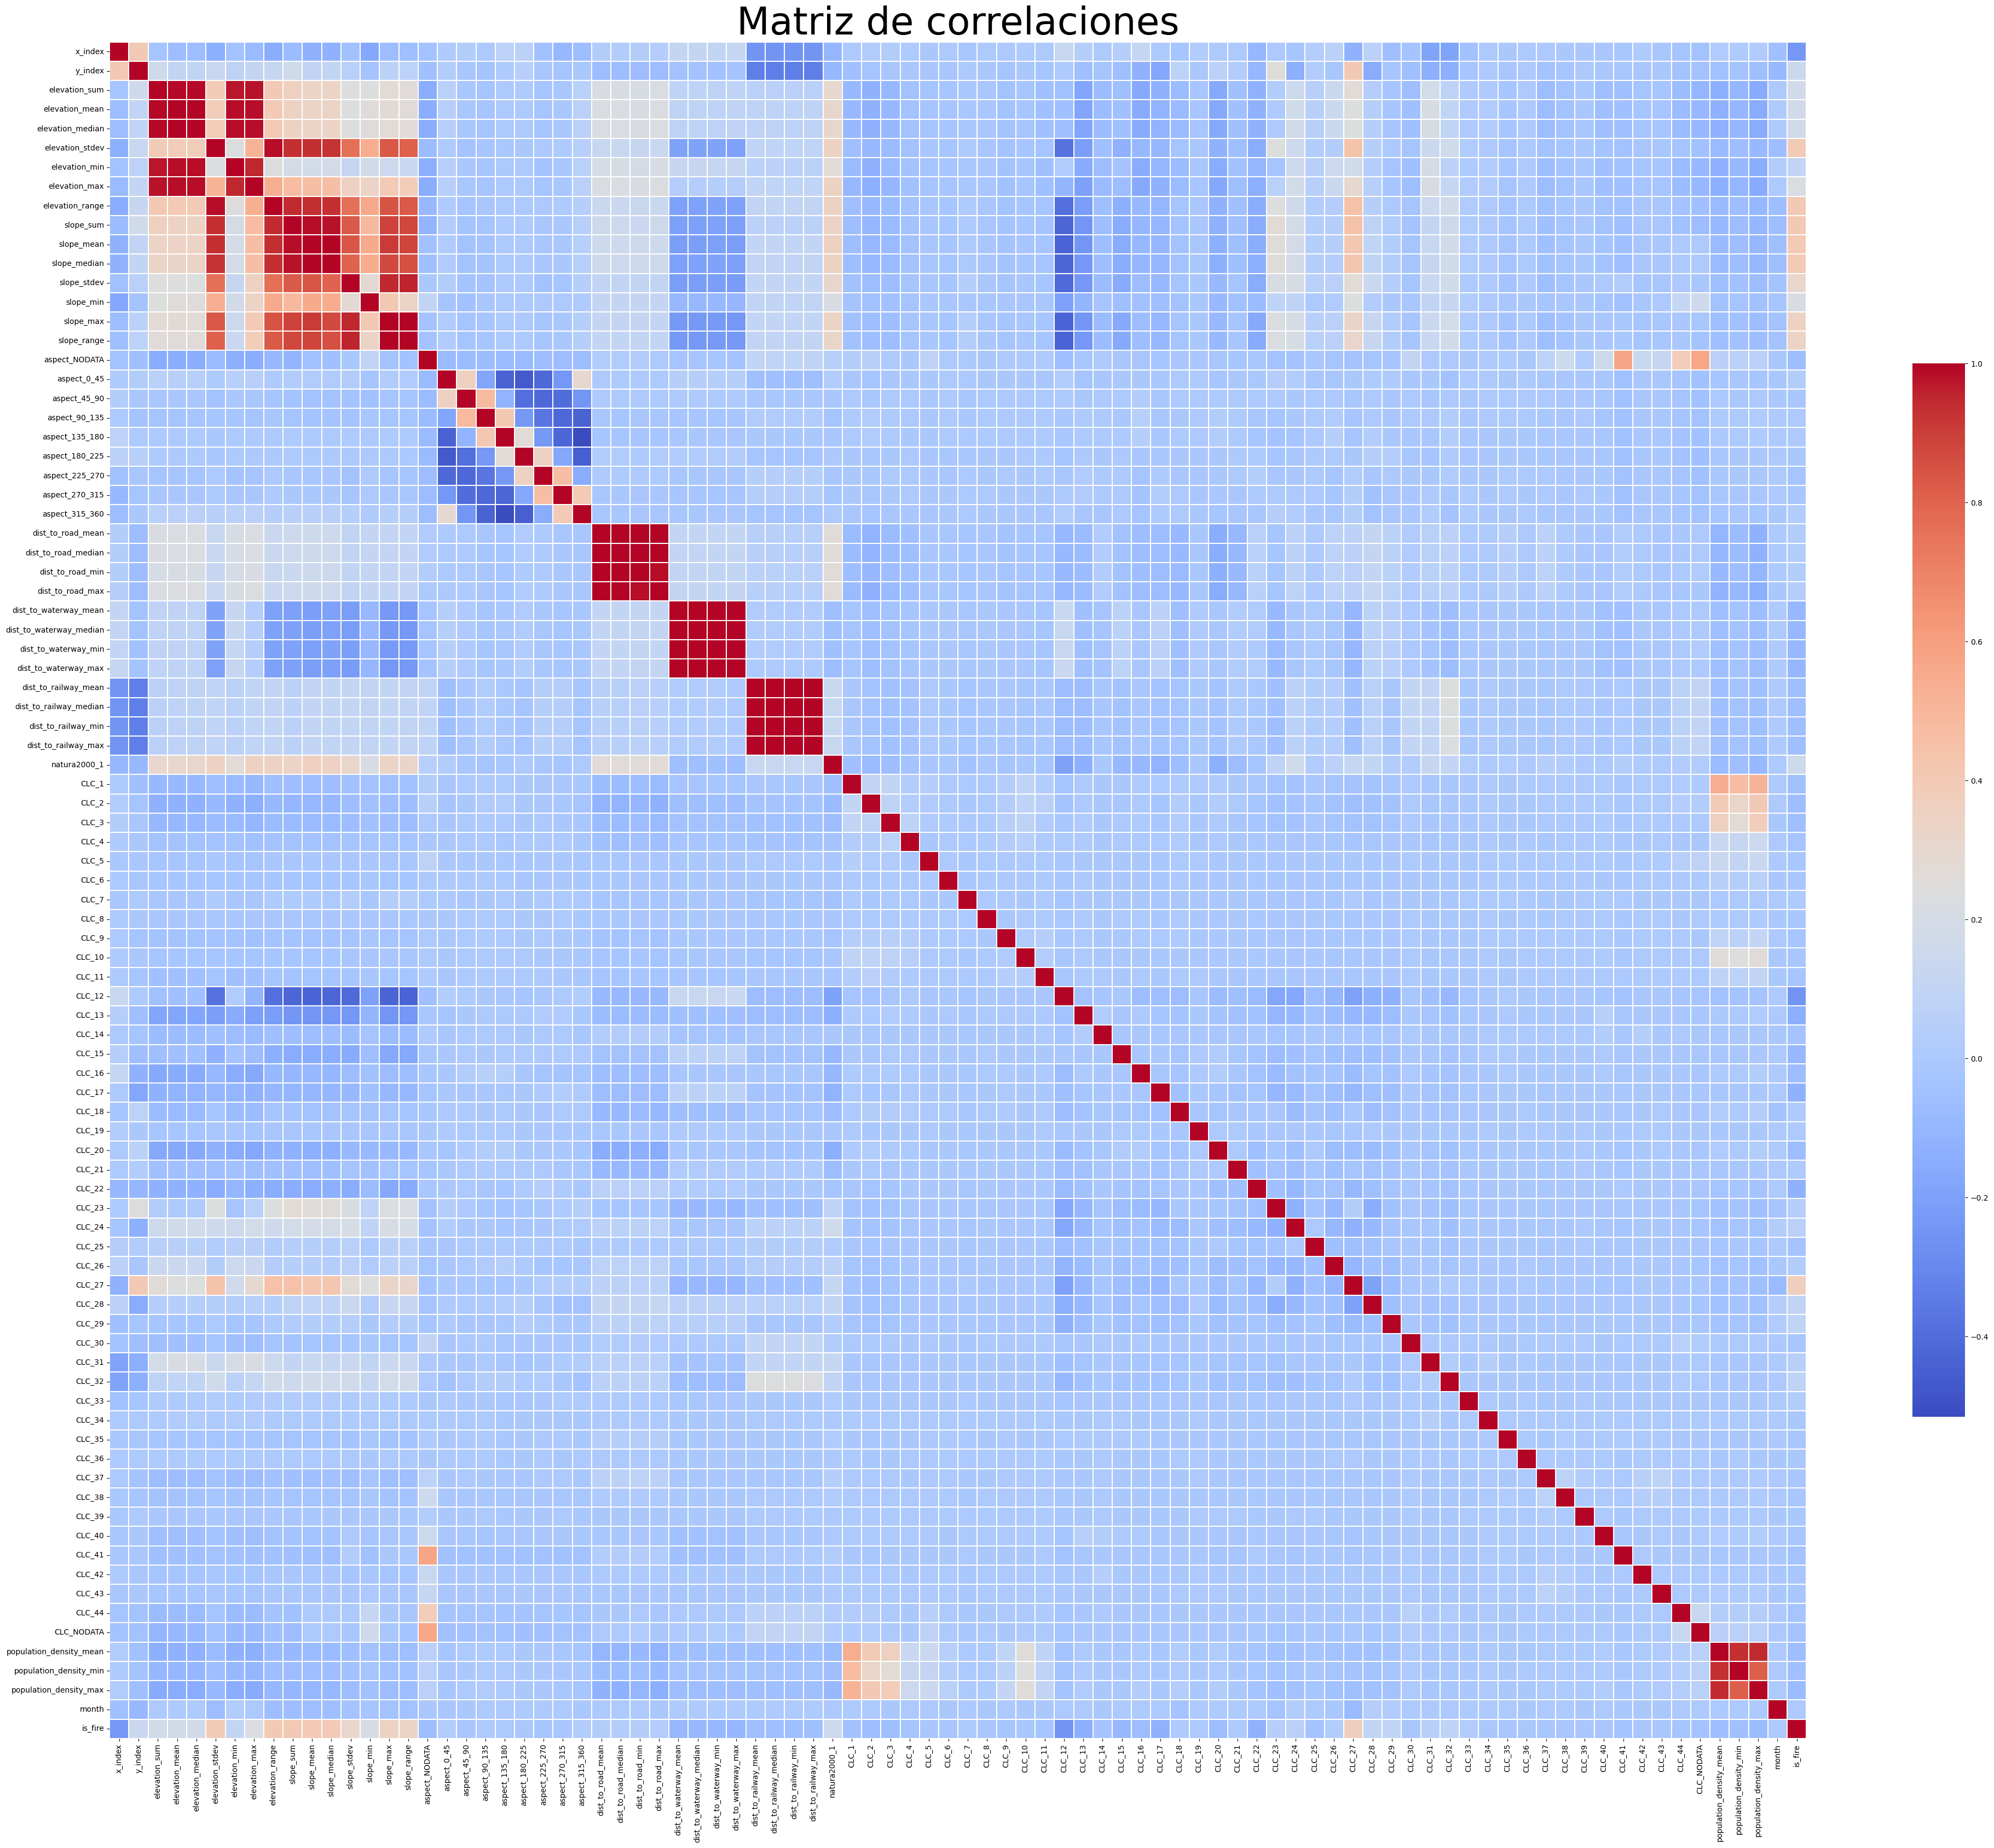

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

aux = df.drop(columns=['initialdate']) # Delete the non-numeric columns
correlation_matrix = aux.corr()

# Visualize the correlation matrix
plt.figure(figsize=(50, 50))
sns.heatmap(
    correlation_matrix, 
    annot=False, 
    cmap='coolwarm', 
    fmt='.2f', 
    cbar=True, 
    square=True, 
    linewidths=0.1,
    cbar_kws={'shrink': 0.5},
)
plt.title('Matriz de correlaciones', fontsize=50)
plt.rc('font', size=30)

# plt.savefig("../data/figures/Corr_matrix.png", bbox_inches="tight", dpi=300)
# plt.clf()

<div style="text-align: center;">
    <img src="../data/figures/Corr_matrix.png" alt="Matriz de correlaciones" width="1500">
</div>

En la matriz de correlaciones vemos como las mayores correlaciones se obtienen entre las variables obtenidas de las mismas fuentes como por ejemplo la elevación media, mediana , mínima, máxima y la suma de elevaciones. Por ahora vamos a dejar dichas variables y no vamos a eliminar las redundantes.

Por otro lado, si nos fijamos en la variable predictora, las variables que más correlación tienen con ella son las siguientes:
- elevation_stdev
- elevation_range
- elevation_mean
- slope_sum
- slope_mean
- slope_median
- slope_stdev
- slope_max
- slope_range
- dist_to_waterway_mean
- CLC_12
- CLC_13
- CLC_27

Teniendo en cuenta que las variables que están correlacionadas entre si, vamos a visualizar los histogramas de densidad en base a la clase de "is_fire" de algunas de las variables anteriores:

- elevation_range
- elevation_mean
- slope_mean
- slope_min
- dist_to_waterway_mean
- CLC_12
- CLC_13
- CLC_27

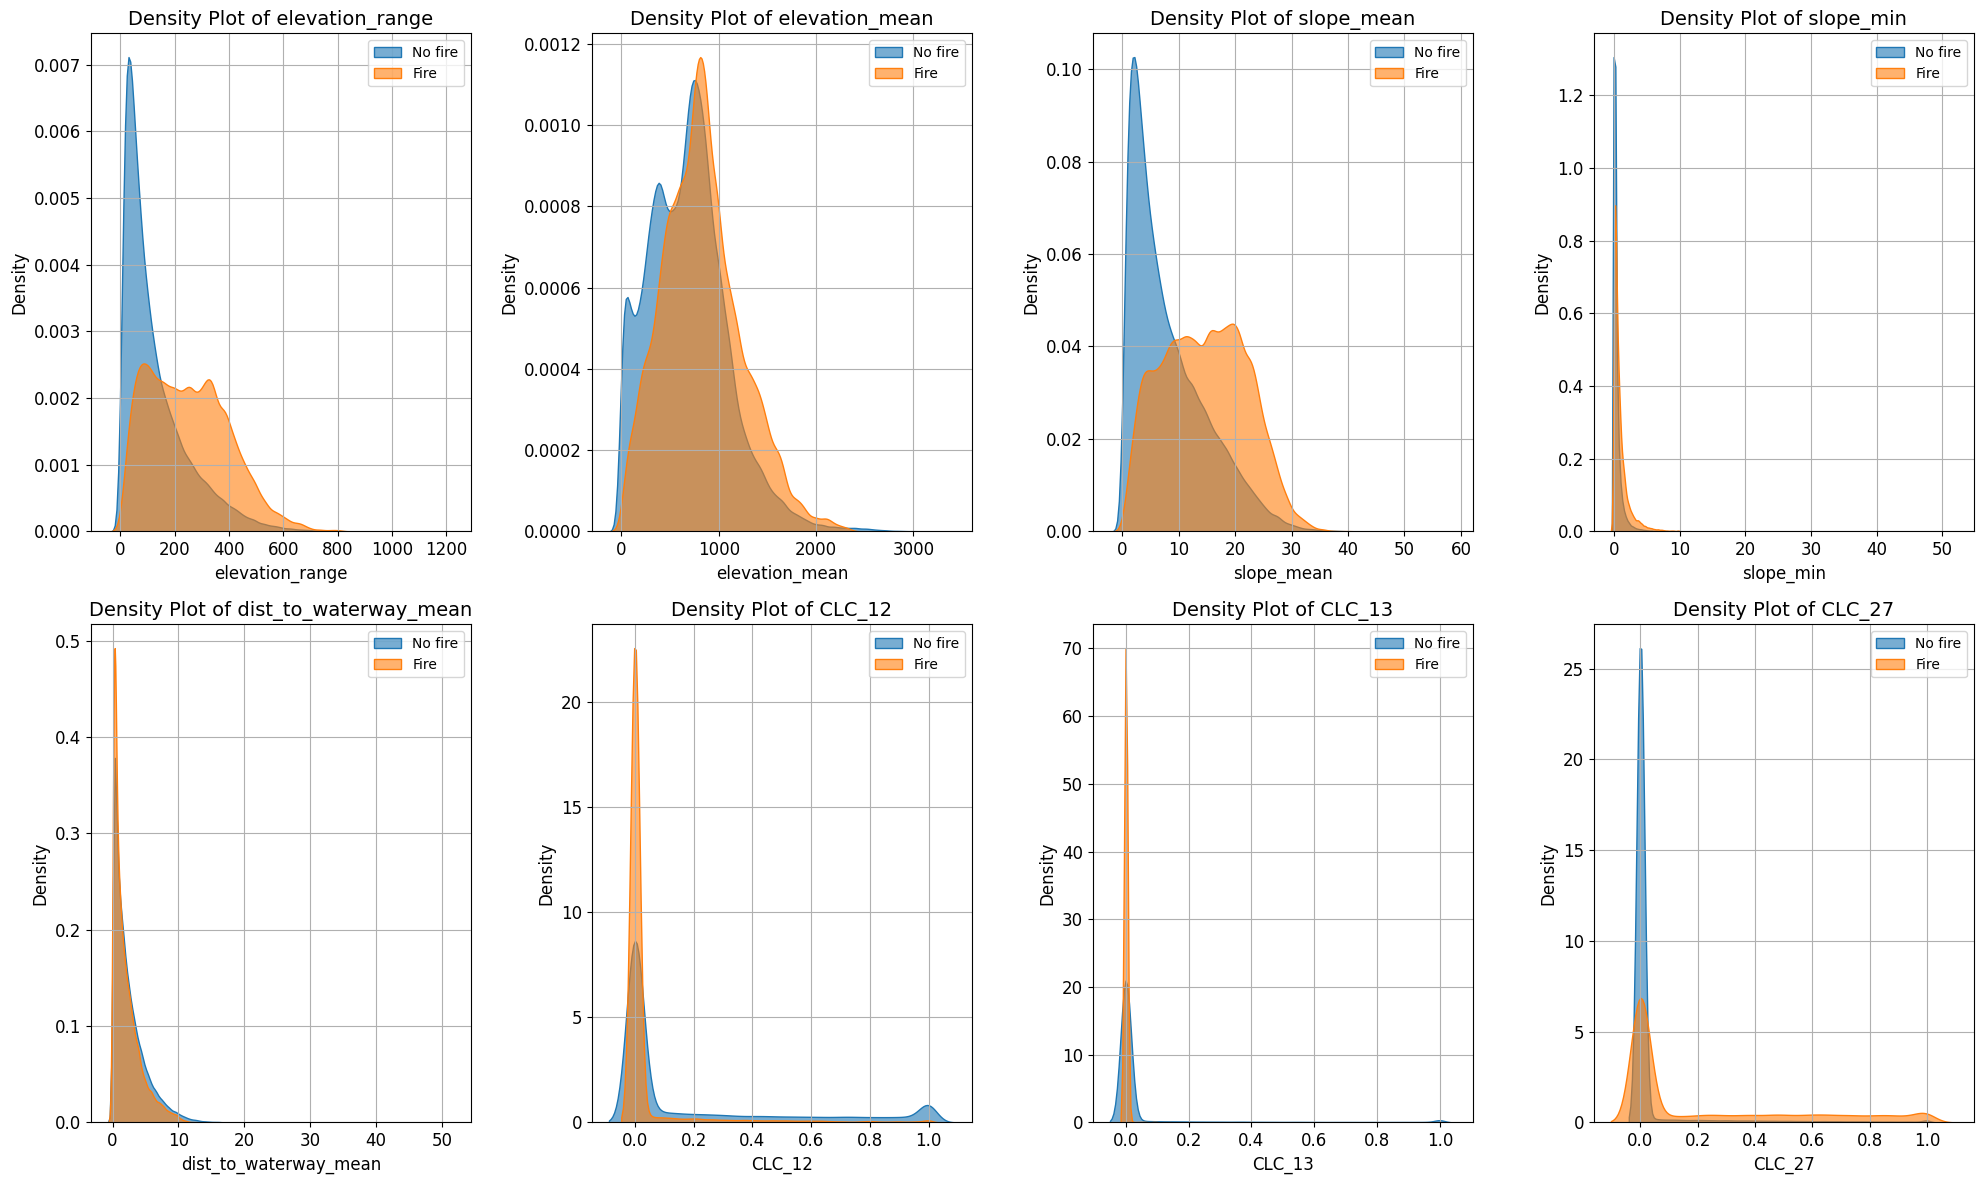

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of column names
columns_to_plot = [
    'elevation_range',
    "elevation_mean",
    'slope_mean',
    'slope_min',
    'dist_to_waterway_mean',
    'CLC_12',
    'CLC_13',
    'CLC_27'
]

plt.rc('font', size=12)

fig, axes = plt.subplots(2, 4, figsize=(20, 12))
axes = axes.flatten()  

# Iterate through columns and axes
for i, column_name in enumerate(columns_to_plot):
    var_fire = df[df['is_fire'] == 1][column_name].values
    var_no_fire = df[df['is_fire'] == 0][column_name].values

    sns.kdeplot(var_no_fire, label="No fire", fill=True, alpha=0.6, ax=axes[i])
    sns.kdeplot(var_fire, label="Fire", fill=True, alpha=0.6, ax=axes[i])

    axes[i].set_title(f'Density Plot of {column_name}', fontsize=14)
    axes[i].set_xlabel(column_name, fontsize=12)
    axes[i].set_ylabel('Density', fontsize=12)
    axes[i].legend(fontsize=10)
    axes[i].grid(True)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

De estos gráficos de densidades podemos concluir que para ciertas variables, como elevation_range elevation_mean y slope_mean, existe una superposición significativa entre las distribuciones de "Fire" y "No Fire". Aunque estas variables tengan una tendencia a ser máyores para el caso de "Fire", como la superposición de las distribuciones es muy grande puede que no sean particularmente útiles para diferenciar entre áreas propensas a incendios. 

Sin embargo, en las variables CLC_12, CLC_13 y CLC_27, se observan diferencias notables en las densidades entre los incendios y las áreas sin incendios. Esto sugiere que ciertos tipos de cobertura terrestre están más asociados con la ocurrencia de incendios. Por ejemplo, las clases 12 y 13 de Corine Land Cover son poco propensas a tener incendios, mientras que la clase 27 es más propensa a tenerlos.

Por último, en cuanto al impacto de la topografía, es difícil sacar conclusiones ya que ambas distribuciones son muy parecidas. Esto indica que puede que las variables no sean muy útiles a la hora de predecir los incendios.

### Valores NA

Como hemos usado diferentes fuentes de datos para crear el conjunto de datos final, en el proceso de creación han aparecido algunos valores perdidos. Esto puede deberse a la falta de exactitud en algunos mapas, o a que en algunas celdas espaciales no haya información sobre algunas variables por razones desconocidas. Analizemos ahora cuántos valores perdidos tenermos.

In [4]:
# Columns with no missing values
missing_columns = [col for col in df.columns if not df[col].notna().all()]
print("Columnas con valores perdidos:", missing_columns)

Columnas con valores perdidos: ['slope_mean', 'slope_median', 'slope_stdev', 'slope_min', 'slope_max', 'slope_range', 'dist_to_road_mean', 'dist_to_road_median', 'dist_to_road_min', 'dist_to_road_max', 'dist_to_waterway_mean', 'dist_to_waterway_median', 'dist_to_waterway_min', 'dist_to_waterway_max', 'population_density_mean', 'population_density_min', 'population_density_max']


In [5]:
aux = df[missing_columns]
missing_counts = aux.isna().sum()
missing_percentage = (aux.isna().sum() / len(aux)) * 100

missing_summary = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Percentage': missing_percentage
}).sort_values(by='Missing Count', ascending=False)

missing_summary


,Missing Count,Missing Percentage
population_density_max,193,0.081909
population_density_min,193,0.081909
population_density_mean,193,0.081909
slope_range,147,0.062387
slope_median,147,0.062387
slope_mean,147,0.062387
slope_max,147,0.062387
slope_min,147,0.062387
slope_stdev,147,0.062387
dist_to_road_mean,15,0.006366


Vemos que los valores perdidos son muy pocos, menos del 0.1% por variable. De hecho, si eliminamos las instancias que contienen estos valores perdidos, se eliminarían 338 instancias de 235626, quedandonos con 235288 instancias.

In [6]:
len(df), len(df.dropna()), len(df) - len(df.dropna())

(235626, 235288, 338)

In [7]:
instancias_con_na = df[df.isna().any(axis=1)]
instancias_con_na["is_fire"].value_counts()

is_fire
0    252
1     86
Name: count, dtype: int64

En nuestro caso esto es lo que vamos ha hacer, vamos a eliminar todos los valores perdidos que tenemos. Si introdujesemos en los valores perdidos las medias de las variables (o usasemos otra técnica para añadir otros valores), estaríamos añadiendo características que desconocemos si son las correctas en esas celdas espaciales. Es decir, podríamos introducir valores topográficos (como la pendiente) muy incorrectos para esas celdas, lo cual haría que entrenasemos el algoritmo en instancias que núnca van a existir. Además, como la cantidad de valores perdidos es mínima, y de los 338 valores perdidos, 252 podríamos generarlos de nuevo y obtener instancias de "no-fuego" nuevas sin valores perdidos, eliminarlos no nos hace prácticamente ningún daño.

In [8]:
df.dropna(inplace=True)

## 5. Detección de "outliers"

En esta sección vamos a usar un algoritmo de detección de outliers para encontrarlos en el conjunto de datos. Una vez lo hayamos hecho, vamos a intentar descubrir por qué son outliers y si tiene sentido eliminarlos, ya que por cómo hemos generado el dataset, tener outliers significa que hay celdas espaciales que son "extrañas" o "poco comunes" en el territorio español.

El algoritmo que vamos a utilizar será el algoritmo de "Isolation Forest", el cual mide el "outlierness" en base a la cantidad de hiperplanos que necesita para aislar una instancia. Utilizando ese algoritmo vamos a dibujar la distribución de los valores de "outlierness" que tienen nuestros datos. Para ello, vamos a introducirle al algoritmo que la proporción de instancias que son outliers es el 1%.

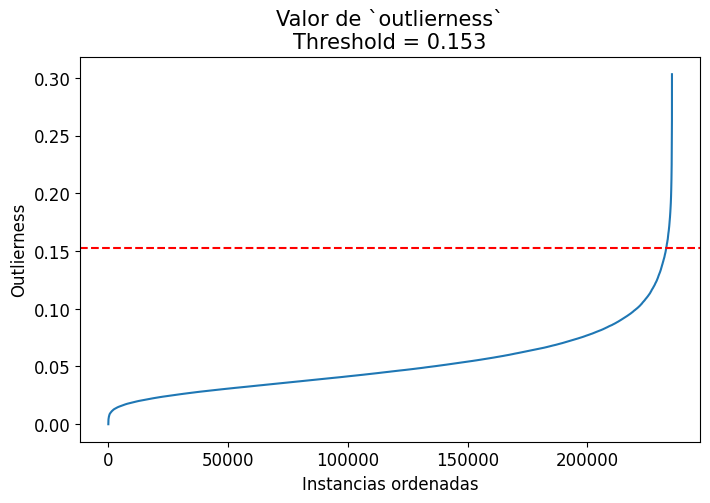

In [9]:
from sklearn.ensemble import IsolationForest
import numpy as np

isolation_forest = IsolationForest(n_estimators=100, 
                                        max_samples='auto', 
                                        contamination=0.01, 
                                        random_state=42)

y_pred = isolation_forest.fit_predict(df.drop(columns=['initialdate', 'is_fire']))
outlier_scores = -isolation_forest.decision_function(df.drop(columns=["initialdate", "is_fire"]))  # Grado de outlierness

# Grafico de outlierness ordenado, con el threshhold marcado:
threshold = np.percentile(outlier_scores, 100 * (1 - isolation_forest.contamination))
sorted = np.sort(outlier_scores)
min_val = sorted[0]
sorted = sorted + abs(min_val)
threshold = threshold + abs(min_val)
outlier_scores = outlier_scores + abs(min_val)
colors = ['blue' if value < threshold else 'red' for value in sorted]
# Plot the sorted data with colors
plt.figure(figsize=(8, 5))
plt.plot(range(len(sorted)), sorted)
plt.xlabel("Instancias ordenadas")
plt.ylabel("Outlierness")
plt.title(f"Valor de `outlierness`\nThreshold = {np.round(threshold,3)}", fontsize=15)
plt.axhline(y=threshold, color='red', linestyle='--')
plt.show()

In [10]:
outliers = df[outlier_scores > threshold]

### 5.1 ¿Por qué son outliers?

Ahora que hemos identificado los outliers, vamos a encontrar la razon por la cual son outliers. Lo primero que vamos a hacer es, ya que tenemos información geográfica, visualizar dónde están los outliers.

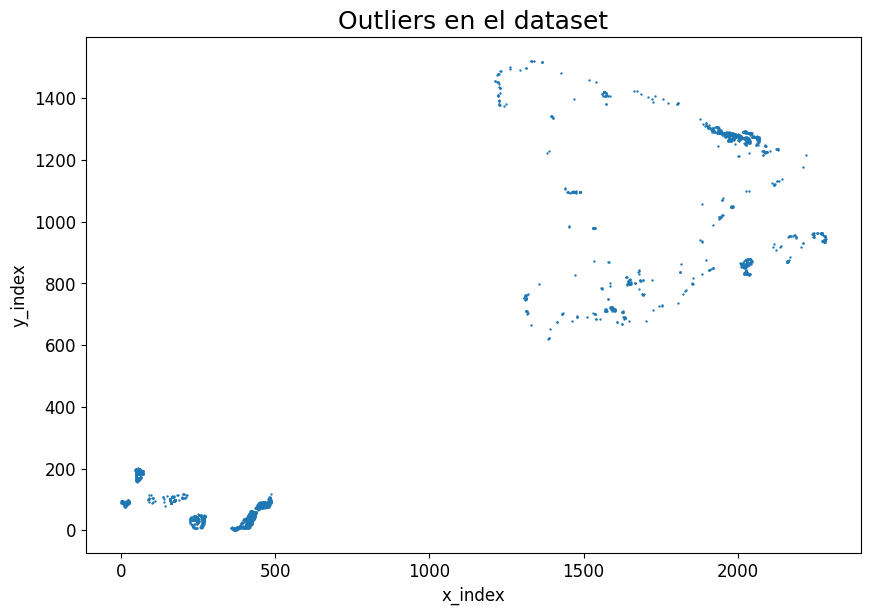

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
scatter = ax.scatter(
    outliers["x_index"], 
    outliers["y_index"],
    s=0.5 
)
ax.set_aspect('equal', 'box')
ax.set_xlabel("x_index")
ax.set_ylabel("y_index")
ax.set_title("Outliers en el dataset", fontsize=18)
plt.show()

Vemos que la mayoría de outliers se encuentran en los pirineos, en las islas baleares y en las islas canarias. Esto puede darnos una pista del porqué esas instancias son outliers: puede ser por la elevación del terreno (en el caso de los pirineos por ejemplo). Con esa información en mente hemos dibujado gráficos de densidad de los outliers y los hemos comparado con los gráficos de densidad de todo el conjunto de datos. Las variables con gráficos más diferentes que hemos encontrado son los siguientes:

- Elevación
- Distancia a vias de tren
- Distancia a carreteras

Además, también hemos observado que los outliers que hemos obtenido no siguen la distribución de "fuego" y "no-fuego" que tienen los datos: hay muchos mas outliers "no-fuego" que outliers "fuego". La proporción es de alrededor de 5 instancias de "fuego" por cada instancia de "fuego", mientras que en el conjunto de datos entero la proporción es de 2 a 1.

In [12]:
outliers["is_fire"].value_counts()

is_fire
0    1983
1     370
Name: count, dtype: int64

Visualicemos las distribuciones de las variables "elevación" (cualquiera de ellas, ya que estan muy correlacionadas) y "distancia a vias de tren". Para ello graficaremos las distribuciones de los datos para el conjunto de datos entero y para los outliers. Además, visualizaremos los datos geográficos y dibujaremos el color en base al valor de las variables:

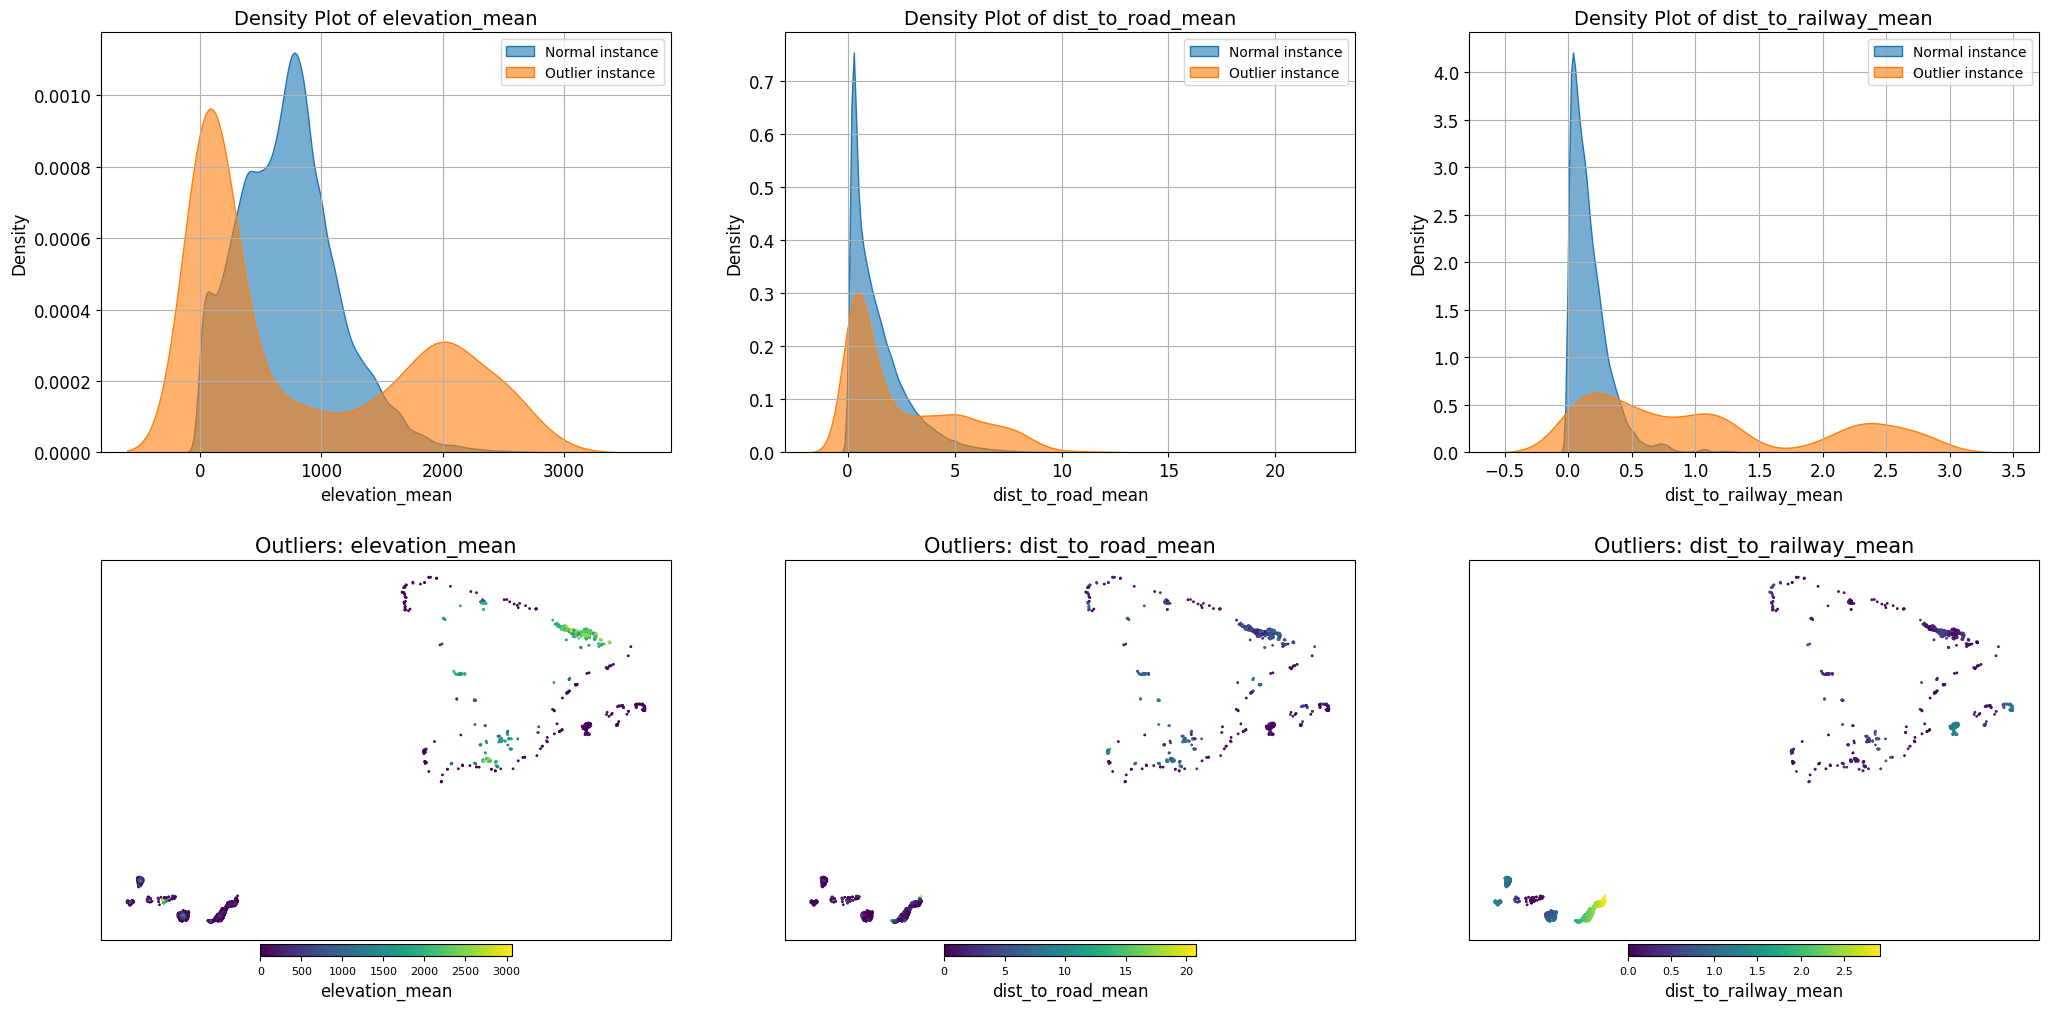

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(25, 12))  

columns = ["elevation_mean", "dist_to_road_mean", "dist_to_railway_mean"]

for i, col in enumerate(columns):

    # Density plot
    var_normals = df[col].values
    var_outliers = outliers[col].values
    sns.kdeplot(var_normals, label="Normal instance", fill=True, alpha=0.6, ax=axes[0,i])
    sns.kdeplot(var_outliers, label="Outlier instance", fill=True, alpha=0.6, ax=axes[0,i])

    axes[0,i].set_title(f'Density Plot of {col}', fontsize=14)
    axes[0,i].set_xlabel(col, fontsize=12)
    axes[0,i].set_ylabel('Density', fontsize=12)
    axes[0,i].legend(fontsize=10)
    axes[0,i].grid(True)

    # Geographic plot
    scatter = axes[1,i].scatter(
    outliers["x_index"], 
    outliers["y_index"], 
    c=outliers[col], 
    cmap='viridis',  # Choose a colormap, e.g., 'viridis', 'plasma', etc.
    s=1  # Adjust marker size
    )
    # Add a colorbar for reference
    cbar = plt.colorbar(scatter, ax=axes[1,i], label=col, orientation='horizontal', fraction=0.03, pad=0.01)
    cbar.ax.tick_params(labelsize=8)
    axes[1,i].set_aspect('equal', 'box')
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])
    axes[1,i].set_title("Outliers: " + col, fontsize=15)

Vemos como claramente los outliers que se encuentran en los pirineos son detectados como outliers porque tienen una elevación mucho más alta que el resto del territorio que estamos analizando. De hecho, si nos fijamos en la media de elevación, observamos como en los outliers por un lado tenemos elevaciones muy bajas (muchos puntos en las partes costeras de España) y elevaciones muy altas (los pirineos).

Por otro lado, también se ve claramente que los outliers tienen mayor distancia a carreteras que la distribución general que siguen los datos. Esto puede deberse a que los outliers tienen elevación más alta y que en esas localizaciones no hay carreteras. De hecho, se ve claramente la relación entre el primer y segundo gráfico de la parte inferior: los outliers con mayor valor de distancia a carreteras tienen una elevación media alta.

Por último, en cuanto a distancia a vias de tren, lo más destacable son las Islas Canarias. Por los datos de Open Street Map que hemos utilizado para crear la capa de distancia a carreteras, en algunas islas no hay vias de tren por lo que si añadimos la distancia entre las islas, obtenemos valores muy altos. Esto puede indicarnos que <u>debamos añadir un máximo en el valor de esa variable</u>.

Como vemos, los outliers que obtenemos son localizaciones con propiedades poco comunes, sin embargo eliminarlos del conjunto de datos no nos interesa, ya que también queremos calcular el riesgo de incendio en esas localizaciones "extrañas". Si las eliminasemos el algoritmo no sabría qué hacer en esas instancias a la hora de predecir riesgo de incendio en todo el territorio. Por todo ello, no las vamos a eliminar.

## 6. PCA y t-SNE

## 7. Preproceso de los datos previo a los entrenamientos

- Minmax, ...
- Qué hacer con los NA values

## 8. Partición de entrenamiento, validación y test

## 8. Entrenamiento

- Qué metrica de evaluación?

## 9. Comparativa estadística de los modelos

## 10. Class Imbalance

## 11. Interpretable Machine Learning: SHAP values

## 12. Mapas de riesgo 